# Data exploration

In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

from cataclop.core.models import *

from cataclop.ml.preprocessing import append_hist, model_to_dict

In [8]:
hippos = Hippodrome.objects.all()
hippos = [ model_to_dict(hippo) for hippo in hippos ]
hippos_df = pd.DataFrame.from_records(hippos, index="id")
hippos_df.index.name = "hippodrome_id"

for c in ["country"]:
    hippos_df[c] = hippos_df[c].astype("category")

### Hippodromes / country

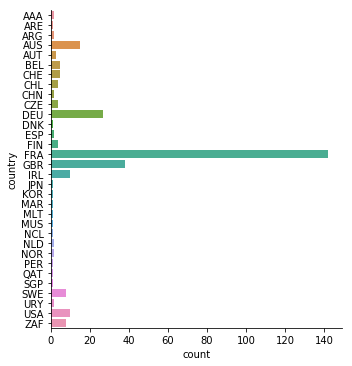

In [9]:
sns.catplot(y="country", kind="count", data=hippos_df)

In [67]:
races = Race.objects.all().prefetch_related("player_set", "session")

sessions = [race.session for race in races]
sessions = list( map(lambda s: model_to_dict(s), set(sessions)) )

sessions_df = pd.DataFrame.from_records(sessions, index="id")
sessions_df.index.name = "session_id"
sessions_df = sessions_df.join(hippos_df, on="hippodrome_id", lsuffix="_session", rsuffix="_hippo")

players = [ model_to_dict(p) for race in races for p in race.player_set.all() ]

races = [ model_to_dict(race) for race in races ]
races_df = pd.DataFrame.from_records(races, index="id")
races_df.index.name = "race_id"
races_df["start_at"] = pd.to_datetime(races_df["start_at"])

races_df = races_df.join(sessions_df, on="session_id", lsuffix="_race", rsuffix="_session")
races_df["date"] = pd.to_datetime(races_df["date"])

for c in ["category", "condition_age", "condition_sex", "sub_category"]:
    races_df[c] = races_df[c].astype("category")

In [46]:
races_df.columns

Index(['category', 'condition_age', 'condition_sex', 'declared_player_count',
       'distance', 'imported_at', 'num_race', 'num_bis', 'prize', 'session_id',
       'start_at', 'sub_category', 'date', 'hippodrome_id',
       'imported_at_session', 'num_session', 'code', 'country',
       'imported_at_hippo', 'name', 'one', 'races_before'],
      dtype='object')

### Races / country

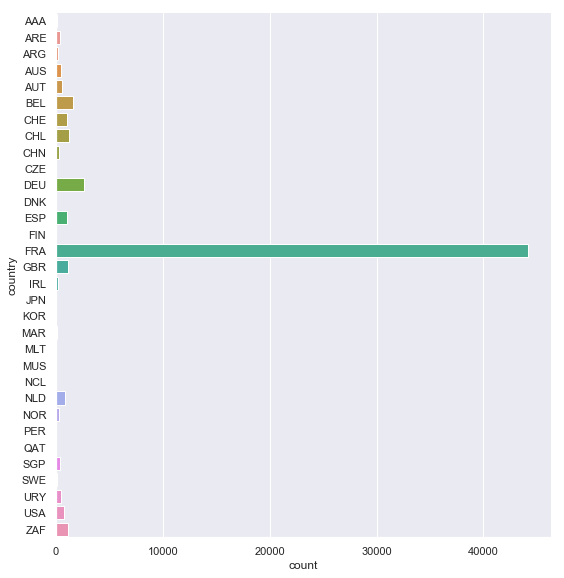

In [25]:
sns.catplot(y="country", kind="count", data=races_df, height=8)

### Races / type

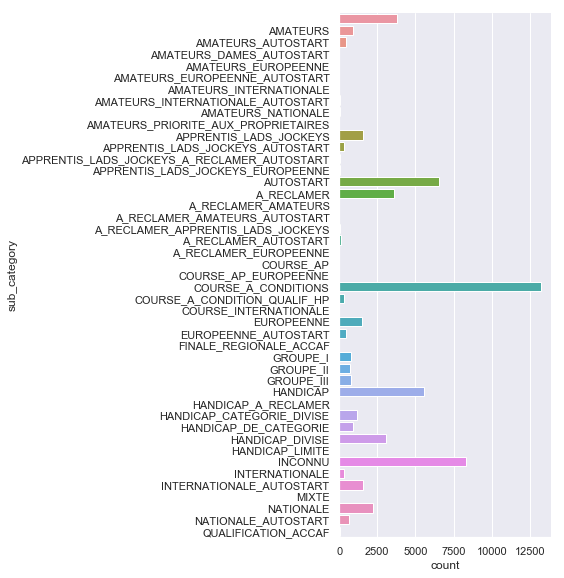

In [27]:
sns.catplot(y="sub_category", kind="count", data=races_df, height=8)

### Evolution of #races for main categories

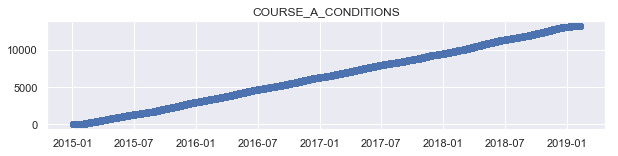

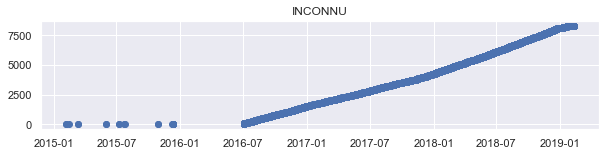

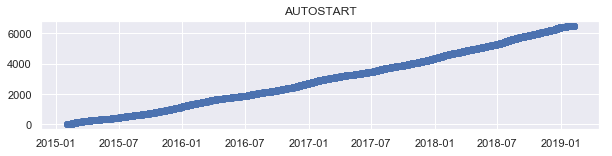

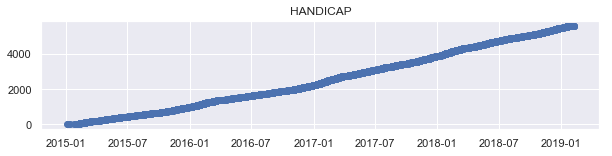

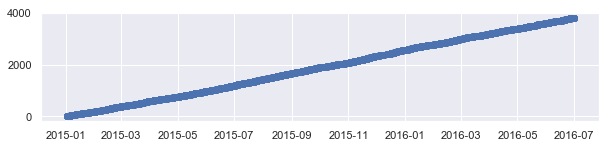

In [38]:
for cat in list(races_df['sub_category'].value_counts().index[0:5]):
    r = races_df[races_df['sub_category']==cat].sort_values(by='start_at', ascending=True)
    r['one'] = 1
    r['races_before'] = r['one'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_title(cat)
    ax.plot_date(r['start_at'], r['races_before'])
    plt.show()

### Prize log distribution

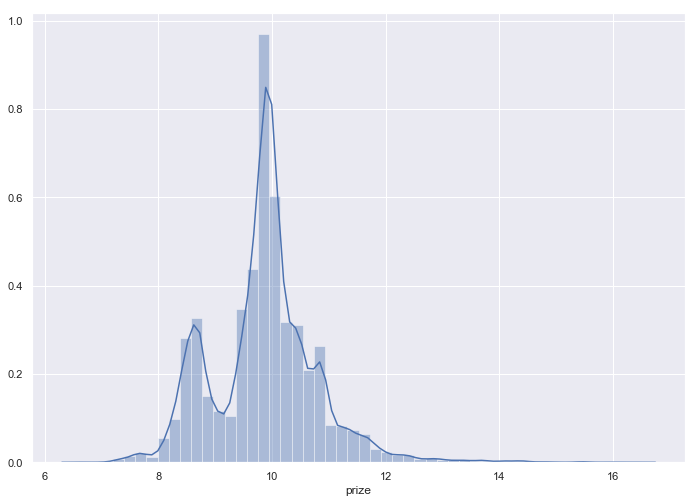

In [41]:
sns.distplot(np.log(races_df['prize']+1))

### #runner distribution

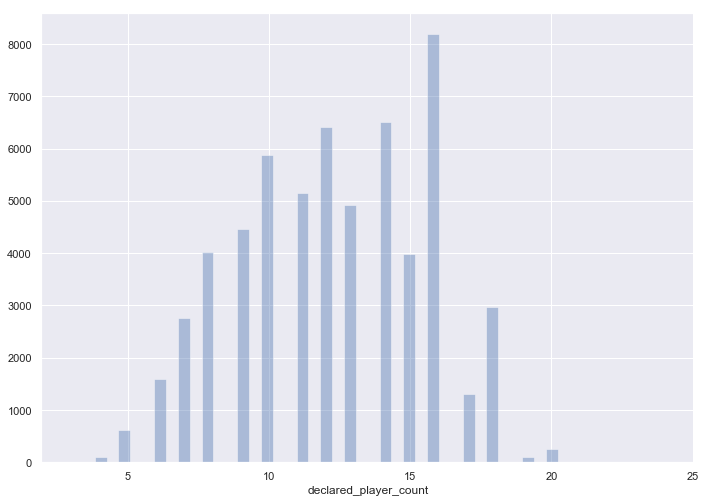

In [43]:
sns.distplot(races_df['declared_player_count'], kde=False)

### Races / hippodromes

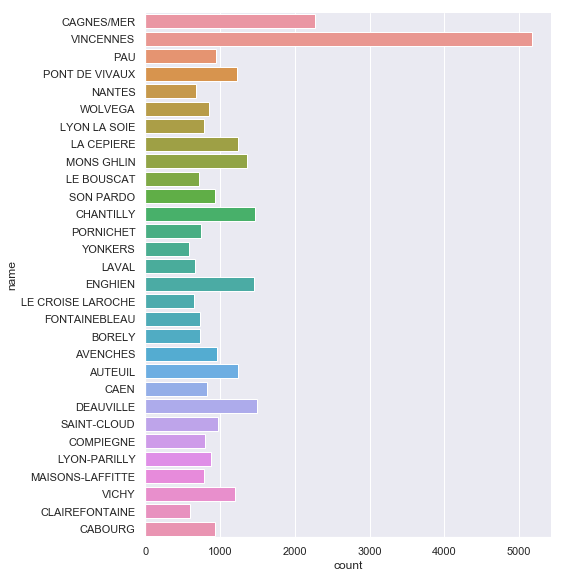

In [53]:
main_hippos = list(races_df['name'].value_counts()[0:30].index)
sns.catplot(y="name", kind="count", data=races_df[(races_df['name'].isin(main_hippos))], height=8)

In [68]:
df = pd.DataFrame.from_records(players, index="id")
df = df.join(races_df, on="race_id", lsuffix="_player", rsuffix="_race")


In [66]:
df['winner_dividend'] /= 100.
df[df['position']==1][['winner_dividend', 'final_odds_unibet', 'final_odds_ref', 'final_odds_ref_unibet']].describe()

,winner_dividend,final_odds_unibet,final_odds_ref,final_odds_ref_unibet
count,32626.000000,1358.000000,39115.000000,1358.000000
mean,0.000884,10.916716,9.773095,11.704860
std,0.001135,15.619291,12.690028,16.211509
min,0.000110,1.100000,1.100000,1.100000
25%,0.000310,3.200000,3.600000,3.600000
50%,0.000540,5.800000,6.500000,6.900000
75%,0.001010,12.075000,11.600000,12.875000
max,0.021180,204.300000,546.600000,242.500000


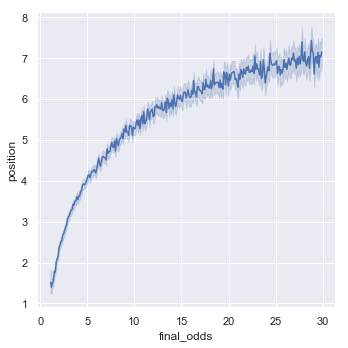

In [65]:
sns.relplot(x="final_odds", y="position", kind="line", data=df[df['final_odds']<30])

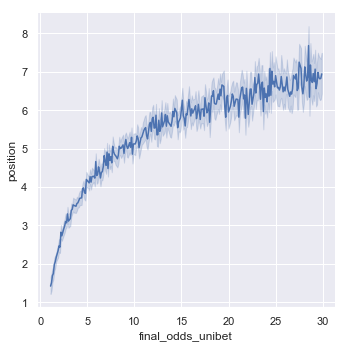

In [69]:
sns.relplot(x="final_odds_unibet", y="position", kind="line", data=df[df['final_odds_unibet']<30])